In [1]:
!wget https://raw.githubusercontent.com/lablnet/covid19/main/analysis/dailyStats.csv

--2022-05-05 05:14:46--  https://raw.githubusercontent.com/lablnet/covid19/main/analysis/dailyStats.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16448 (16K) [text/plain]
Saving to: ‘dailyStats.csv’

dailyStats.csv      100%[===================>]  16.06K  --.-KB/s    in 0s      

2022-05-05 05:14:47 (64.9 MB/s) - ‘dailyStats.csv’ saved [16448/16448]



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


In [3]:
#read /content/dailyStats.csv

df=pd.read_csv('./dailyStats.csv')
df.head()

,sr#,datetime,new_cases,
0,1,2020-03-17,25,NaN
1,2,2020-02-26,1,NaN
2,3,2020-03-15,2,NaN
3,4,2020-03-18,9,NaN
4,5,2020-03-14,1,NaN


In [4]:
#make datetime as index
df.index = pd.PeriodIndex(df['datetime'], freq="D")
#remove datetime column
df.drop(['datetime'], axis=1, inplace=True)
df.drop(['sr# '], axis=1, inplace=True)

In [5]:
#remove column wih null values
df = df[df.columns[~df.isnull().all()]]
df

,new_cases
datetime,
2020-03-17,25
2020-02-26,1
2020-03-15,2
2020-03-18,9
2020-03-14,1
...,...
2022-04-20,69
2022-04-21,103
2022-04-22,77


<AxesSubplot:xlabel='datetime'>

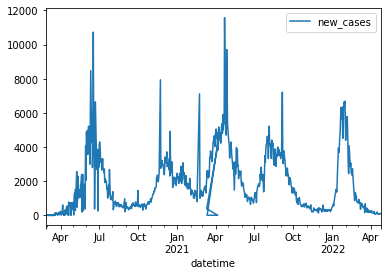

In [6]:
df.plot()

In [7]:
yearly=df.resample("Y").agg(["mean", "median", "std"])
yearly

new_cases                     
                 mean  median          std
datetime                                  
2020      1407.512121   724.5  1579.015218
2021      2120.827869  1717.5  1652.508682
2022      1822.327434   793.0  2032.042975

<AxesSubplot:xlabel='datetime'>

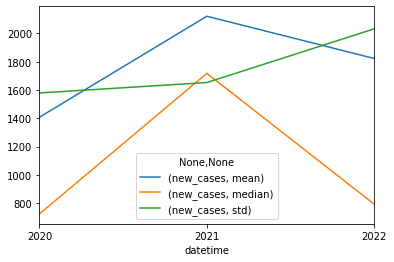

In [8]:
yearly.plot()

In [9]:
df.index.month

Int64Index([3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='datetime', length=809)

<AxesSubplot:xlabel='datetime'>

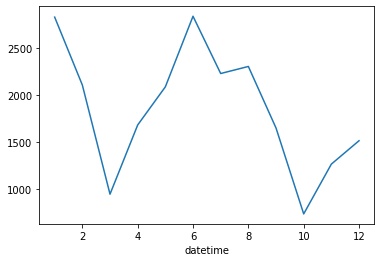

In [10]:
#monthly average cases
df.groupby(df.index.month).new_cases.mean().plot()

<AxesSubplot:title={'center':'monthly cases'}, xlabel='datetime'>

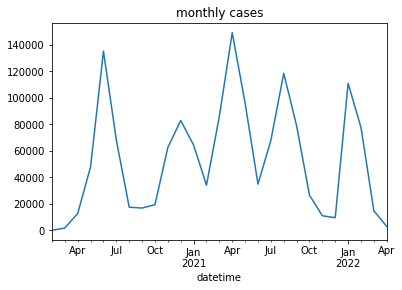

In [11]:
df.resample('M').new_cases.sum().plot(title="monthly cases")

Let's zoom April

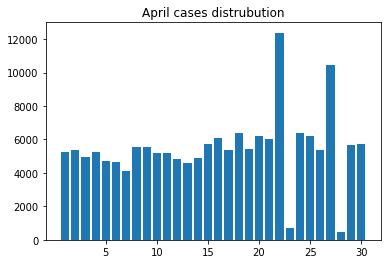

In [12]:

ax = plt.subplot()
plt.bar(range(1, 31),pd.DataFrame(df.new_cases[df.index.month==4]).groupby(lambda x: (x.day)).new_cases.sum())
ax.set_title("April cases distrubution")
ax.set_xticks(ticks=range(5, 31, 5))

Trend

In [13]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(df.index, model='additive')  
# result.plot();

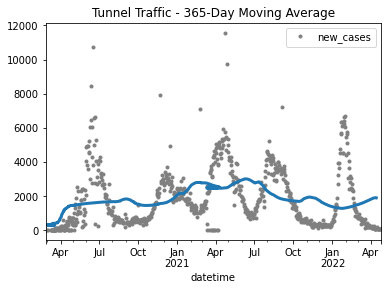

In [14]:
moving_average = df.rolling(
    window=180,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=100,  # choose about half the window size
).mean()  
ax = df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);
#plot show that trend is non linear

In [15]:

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared
datetime,,,
2020-03-17,1.0,1.0,1.0
2020-02-26,1.0,2.0,4.0
2020-03-15,1.0,3.0,9.0
2020-03-18,1.0,4.0,16.0
2020-03-14,1.0,5.0,25.0


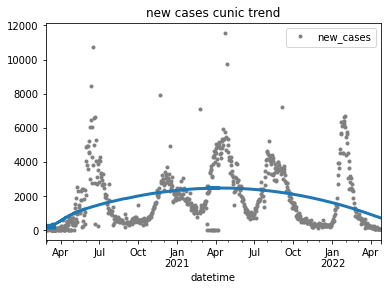

In [16]:
#fitting regression model
y =df["new_cases"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = df.plot(style=".", color="0.5", title="new cases cunic trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [17]:
#future prediction
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-04-25    721.918495
2022-04-26    712.552667
2022-04-27    703.161932
2022-04-28    693.746290
2022-04-29    684.305742
Freq: D, dtype: float64

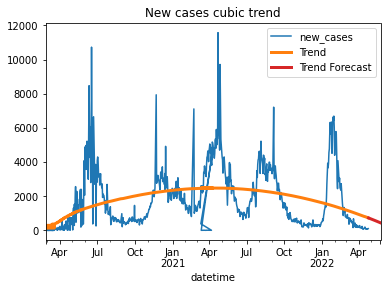

In [18]:
ax = df.plot(title="New cases cubic trend")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

Seanality

In [19]:

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,
   # drop terms to avoid collinearity
)

x=dp.in_sample()


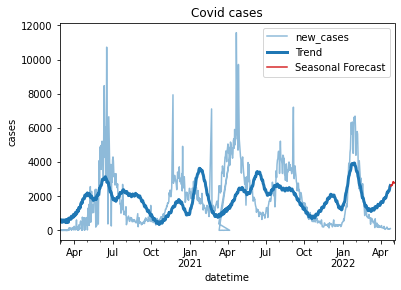

In [20]:
from sklearn.linear_model import LinearRegression
y=df['new_cases']
model = LinearRegression()
model.fit(x, y)

y_pred = pd.Series(model.predict(x), index=x.index)
X_fore = dp.out_of_sample(steps=10)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot( alpha=0.5, title="Covid cases", ylabel="cases")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')

ax.legend();

In [21]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.legend()
y_fore

2022-04-25    2581.704210
2022-04-26    2649.701348
2022-04-27    2669.126794
2022-04-28    2625.621370
2022-04-29    2677.604758
                 ...     
2022-07-19    2804.902255
2022-07-20    2824.027659
2022-07-21    2781.788482
2022-07-22    2836.368912
2022-07-23    2973.225016
Freq: D, Length: 90, dtype: float64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version


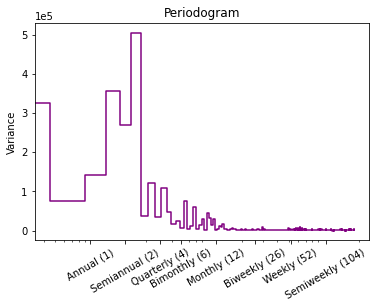

In [22]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax
plot_periodogram(df.new_cases);


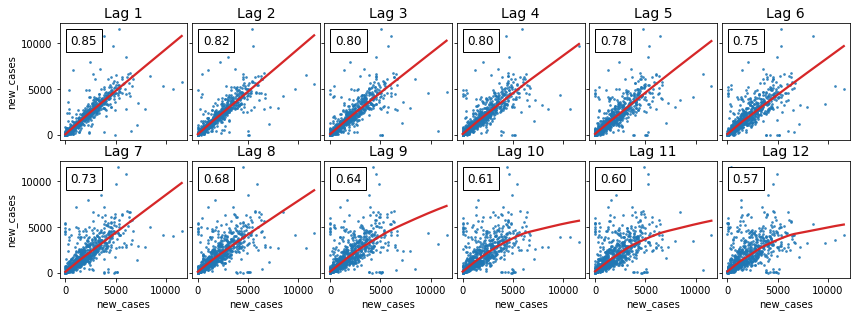

In [23]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig
_ = plot_lags(df.new_cases, lags=12, nrows=2)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


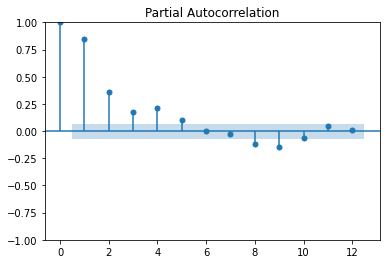

In [24]:
#plotting autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(df.new_cases, lags=12)

In [25]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df.new_cases, lags=6)
X = X.fillna(0.0)
X_f=df.tail(6)
X_f=make_lags(X_f.new_cases,lags=6)
X_f = X_f.fillna(0.0)

In [26]:
y=df.new_cases.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

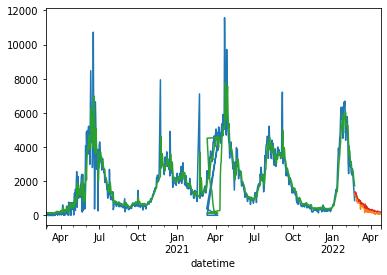

In [27]:
ax = y_train.plot()
ax = y_test.plot()
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

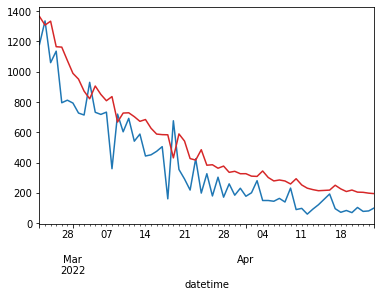

In [28]:
ax = y_test.plot()
_ = y_fore.plot(ax=ax, color='C3')

In [29]:
y_f=pd.Series(model.predict(X_f), index=X_f.index)
#we are going to use this prediction

In [30]:
# import statsmodels.api as sm
# data=df.copy()
# data.index = pd.DatetimeIndex(data.to_timestamp()).to_period('M')
# fit = sm.tsa.arima.ARIMA(data, seasonal_order=(0, 1, 1, 7)).fit()
# fit.summary()


In [31]:
# fit.forecast(100).plot()

Hybrid

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


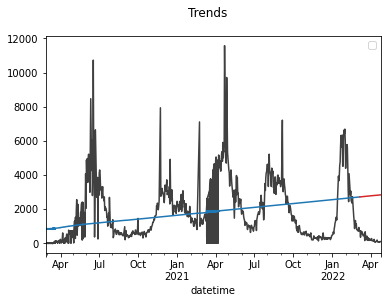

In [32]:
y=df.copy()
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample() 
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [33]:
X=df.copy()
X["day"] = X.index.day  # values are day of the month
X=X.drop(['new_cases'],axis=1)


In [34]:
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]


In [35]:
y_resid=y_train-y_fit
y_resid.fillna(0)
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)


# Add the predicted residuals onto the predicted trends
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

<AxesSubplot:xlabel='datetime,None'>

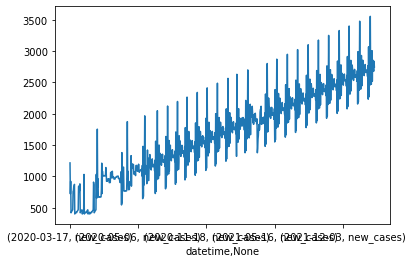

In [36]:
y_fit_boosted.plot()

In [37]:
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- day
Feature names seen at fit time, yet now missing:
- const
- trend

  warnings.warn(message, FutureWarning)


ValueError: X has 1 features, but LinearRegression is expecting 2 features as input.

In [ ]:
def make_data_for_forecast(n_days=10):
    f=pd.DataFrame(pd.period_range(start=df.tail(1).index[0],periods=n_days),columns=["datetime"])
    f.index=f['datetime']
    f=f.drop(['datetime'],axis=1)
    f['day']=f.index.day
    return f
def pred_regression(f):
    dp = DeterministicProcess(
    index=f.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
    f_1 = dp.in_sample() 

    y_pred = pd.DataFrame(
    model.predict(f_1),
    index=f.index,
    columns=y.columns)
    return y_pred
def prediction(f):
    y_pred=pred_regression(f)
    y_pred = y_pred.stack().squeeze()
    y_fore_booasted = xgb.predict(f) + y_pred
    return y_fore_booasted

f=make_data_for_forecast(30)
pred=prediction(f)
pred.plot()

In [ ]:
pred=pred.to_frame().unstack()[0]
pred.to_csv('pred.csv')